In [19]:
%load_ext autoreload
%autoreload 2

import models.dataset as ds
import glob
import matplotlib.pyplot as plt
import torch
from pytorch_msssim import ms_ssim
import numpy as np
from torchvision import transforms
from torch.utils.data import DataLoader
from models.util import *

dataset_path = './Data/'
device = "cuda" if torch.cuda.is_available() else "cpu"


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Training Data Size: 7839


/tmp/ipykernel_100450/946457925.py:21: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2,num_show,idx+1)


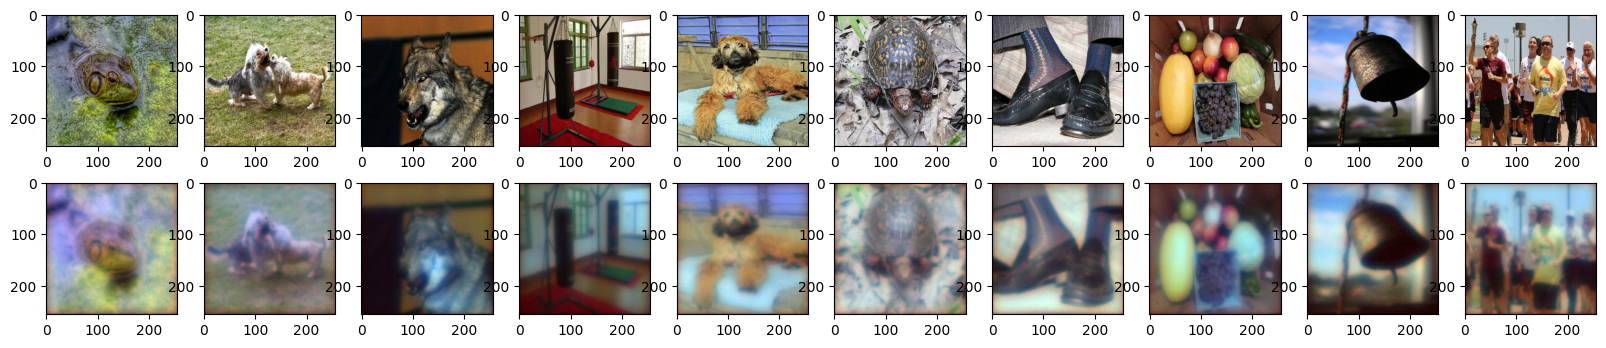

In [8]:
dataset_dict = dict()
for ds_type in ['train','val','test']:
    dataset_dict[ds_type] = dict()
    dataset_dict[ds_type]['path'] = dataset_path + ds_type + '/'
    filepath_all_gt = glob.glob(dataset_dict[ds_type]['path']+'/groundtruth/*')
    filepath_all_blur = glob.glob(dataset_dict[ds_type]['path']+'/input/*')
    dataset_dict[ds_type]['dataset'] = ds.NanoDataset(filepath_all_gt,filepath_all_blur,transform=ds.ToTensor())

dataset_train = dataset_dict['train']['dataset']
dataset_test = dataset_dict['test']['dataset']

dataloader_train = DataLoader(dataset_train, batch_size=8, shuffle=True, num_workers=1)
dataloader_train = DataLoader(dataset_test, batch_size=8, shuffle=True, num_workers=1)

print('Training Data Size:',len(dataset_train))

num_show = 10
plt.figure(figsize=(2*num_show,4))
plt.axis('off')
for idx in range(num_show):
    plt.subplot(2,num_show,idx+1)
    image = dataset_train[idx]['gt'].detach().cpu().numpy()
    plt.imshow(image)
    plt.subplot(2,num_show,idx+1+num_show)
    image = dataset_train[idx]['blur'].detach().cpu().numpy()
    plt.imshow(image)



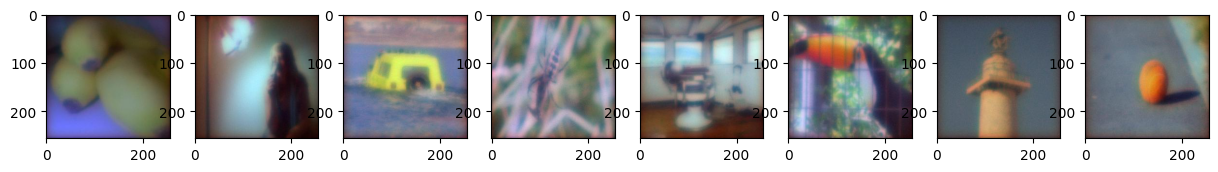

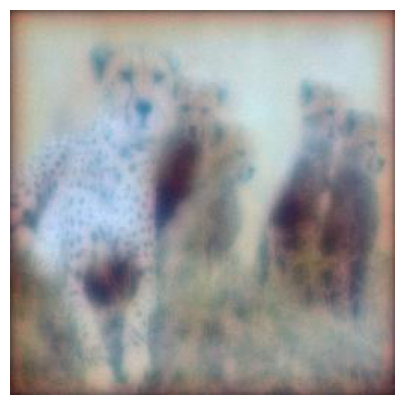

In [21]:
show_tensor_image(next(iter(dataloader_train))['blur'])
show_tensor_first_image(next(iter(dataloader_train))['blur'])

In [21]:
load_path = None
epochs = 1
network = 'unet'
loss_type = 'ssim'

In [22]:
from models.unet3d import Unet
num_in_channels = 1

unet_model = Unet(n_channel_in=num_in_channels, n_channel_out=1, residual=False, down='conv', up='tconv', activation='selu').to(device)
model = unet_model

if load_path is not None:
    model.load_state_dict(torch.load('saved_data/'+load_path,map_location=torch.device(device)))
    print('loading saved model')

lr = 0.001
loss_fn = torch.nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr = lr)

unet_model

Unet(
  (down1): Conv3d(32, 32, kernel_size=(2, 2, 2), stride=(2, 2, 2), groups=32)
  (down2): Conv3d(64, 64, kernel_size=(2, 2, 2), stride=(2, 2, 2), groups=64)
  (down3): Conv3d(128, 128, kernel_size=(2, 2, 2), stride=(2, 2, 2), groups=128)
  (down4): Conv3d(256, 256, kernel_size=(2, 2, 2), stride=(2, 2, 2), groups=256)
  (up1): ConvTranspose3d(256, 256, kernel_size=(2, 2, 2), stride=(2, 2, 2), groups=256)
  (up2): ConvTranspose3d(128, 128, kernel_size=(2, 2, 2), stride=(2, 2, 2), groups=128)
  (up3): ConvTranspose3d(64, 64, kernel_size=(2, 2, 2), stride=(2, 2, 2), groups=64)
  (up4): ConvTranspose3d(32, 32, kernel_size=(2, 2, 2), stride=(2, 2, 2), groups=32)
  (conv1): ConvBlock(
    (conv1): Conv3d(1, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (conv2): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (actfun1): LeakyReLU(negative_slope=0.01)
    (actfun2): LeakyReLU(negative_slope=0.01)
  )
  (conv2): ConvBlock(
    (conv1): Co

In [24]:
best_loss=27e7
import torch.nn as nn

for itr in range(0,epochs):
    for i_batch, sample_batched in enumerate(dataloader_train):
        optimizer.zero_grad()
        #out = model(sample_batched['meas'].repeat(1,32,1,1)[...,18:466,4:644].unsqueeze(0).to(device))
        #x = sample_batched['blur'].permute((0,3,1,2))
        print(sample_batched['blur'].shape)
        x = sample_batched['blur'][:,:,:,0].repeat(1,1,32,1,1).to(device)
        print(x.shape)
        out = model(x)
        #print(out.shape)

        gt = sample_batched['gt'][:,:,:,0].repeat(1,1,32,1,1).to(device)
        

        if loss_type=='l1':
            loss = loss_fn(out, gt)
        else:
            loss = loss_fn(out, gt)+(1- ms_ssim( out, gt.to(device), data_range=1, size_average=False))
        loss.backward()
        optimizer.step()
        print('epoch: ', itr, ' batch: ', i_batch, ' loss: ', loss.item(), end='\r')

        #break 
    
    out_np = out.detach().cpu().numpy()[0][0]
    gt_np = sample_batched['gt'].detach().cpu().numpy()[0][0]
    meas_np = sample_batched['blur'].detach().cpu().numpy()[0][0]

    f, ax = plt.subplots(1, 3, figsize=(15,15))
    ax[0].imshow(gt_np)
    ax[1].imshow(meas_np)
    ax[2].imshow(out_np)
    plt.show()

    if itr%1==0:
        total_loss=0
        for i_batch, sample_batched in enumerate(dataloader_test):
            with torch.no_grad():
                
                out = model(sample_batched['meas'].to(device))
                if loss_type=='l1':
                    loss = loss_fn(out, sample_batched['im_gt'].to(device))
                else:
                    loss = loss_fn(out, sample_batched['im_gt'].to(device))+(1- ms_ssim( out[0], sample_batched['im_gt'][0].to(device), data_range=1, size_average=False))
                
                
                total_loss+=loss.item()
                
                print('loss for testing set ',itr,' ',i_batch, total_loss)
                
            #break
        
        if total_loss<best_loss:
            best_loss=total_loss

           

torch.Size([8, 1, 256, 256, 3])
torch.Size([1, 8, 32, 256, 3])


RuntimeError: Given groups=1, weight of size [32, 1, 3, 3, 3], expected input[1, 8, 32, 256, 3] to have 1 channels, but got 8 channels instead

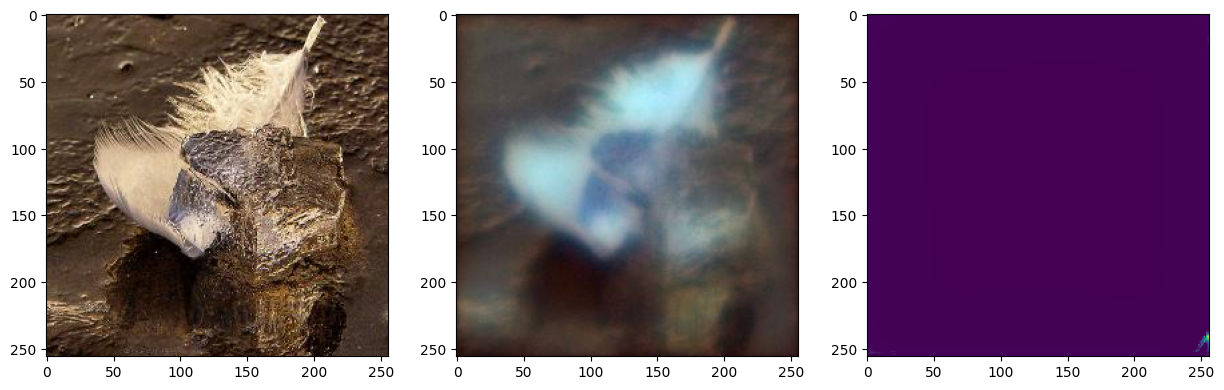

In [16]:
x = sample_batched['blur'][:,:,:,0].repeat(1,1,32,1,1).to(device)
out_np = out.detach().cpu().numpy()[0][0][0]
gt_np = sample_batched['gt'].detach().cpu().numpy()[0]
meas_np = sample_batched['blur'].detach().cpu().numpy()[0]

f, ax = plt.subplots(1, 3, figsize=(15,15))
ax[0].imshow(gt_np)
ax[1].imshow(meas_np)
ax[2].imshow(out_np)
plt.show()